In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import FashionMNIST

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

In [3]:
train_dataset = FashionMNIST('./data',
                             train=True,
                             download=True,
                             transform=transforms.ToTensor())
test_dataset = FashionMNIST('./data',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.7MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 212kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.87MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 22.3MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [5]:
batch_size = 512
train_ratio = 0.9
train_size = int(len(train_dataset) * train_ratio)
val_size = len(train_dataset) - train_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train size: {len(train_subset)}")
print(f"Validation size: {len(val_subset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 54000
Validation size: 6000
Test size: 10000


In [6]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = nn.Sigmoid()(x)
        x = self.layer4(x)
        x = nn.Sigmoid()(x)
        x = self.layer5(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = nn.Sigmoid()(x)
        out = self.output(x)
        return out

input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-2

model = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [7]:
epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 2.3078, Train_Acc: 0.0991, Validation Loss: 2.3028, Val_Acc: 0.0998
EPOCH 2/100, Train_Loss: 2.3028, Train_Acc: 0.0992, Validation Loss: 2.3028, Val_Acc: 0.1013
EPOCH 3/100, Train_Loss: 2.3028, Train_Acc: 0.1003, Validation Loss: 2.3029, Val_Acc: 0.0965
EPOCH 4/100, Train_Loss: 2.3028, Train_Acc: 0.0971, Validation Loss: 2.3031, Val_Acc: 0.0965
EPOCH 5/100, Train_Loss: 2.3028, Train_Acc: 0.0991, Validation Loss: 2.3026, Val_Acc: 0.0998
EPOCH 6/100, Train_Loss: 2.3027, Train_Acc: 0.0978, Validation Loss: 2.3031, Val_Acc: 0.0965
EPOCH 7/100, Train_Loss: 2.3028, Train_Acc: 0.1003, Validation Loss: 2.3028, Val_Acc: 0.1060
EPOCH 8/100, Train_Loss: 2.3028, Train_Acc: 0.0968, Validation Loss: 2.3029, Val_Acc: 0.0948
EPOCH 9/100, Train_Loss: 2.3027, Train_Acc: 0.1001, Validation Loss: 2.3030, Val_Acc: 0.0950
EPOCH 10/100, Train_Loss: 2.3028, Train_Acc: 0.0980, Validation Loss: 2.3028, Val_Acc: 0.0965
EPOCH 11/100, Train_Loss: 2.3028, Train_Acc: 0.0974, Validation Loss:

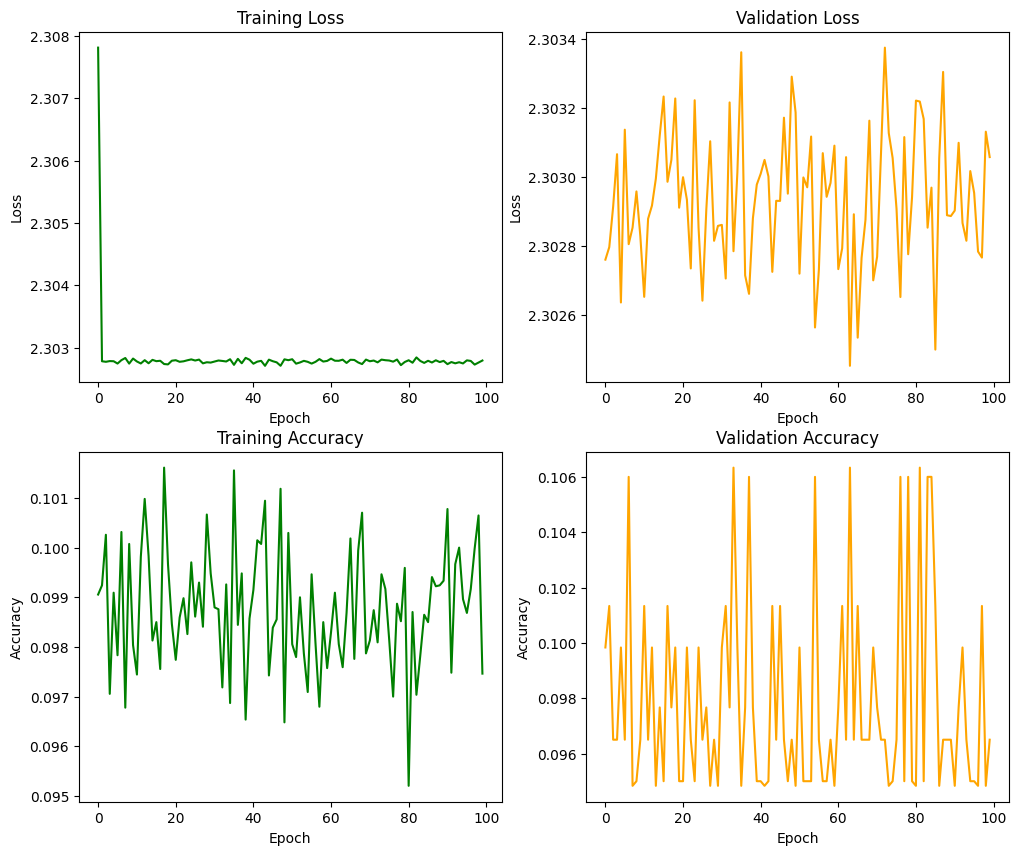

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

ax[0, 0].plot(train_loss_lst, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_loss_lst, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_acc_lst, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_acc_lst, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()

1. Weight Increasing:

In [10]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=1.0)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        x = self.layer3(x)
        x = nn.Sigmoid()(x)
        x = self.layer4(x)
        x = nn.Sigmoid()(x)
        x = self.layer5(x)
        x = nn.Sigmoid()(x)
        x = self.layer6(x)
        x = nn.Sigmoid()(x)
        x = self.layer7(x)
        x = nn.Sigmoid()(x)
        out = self.output(x)
        return out


input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-2

model = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 3.7603, Train_Acc: 0.1592, Validation Loss: 2.2821, Val_Acc: 0.2333
EPOCH 2/100, Train_Loss: 2.0749, Train_Acc: 0.2886, Validation Loss: 1.9341, Val_Acc: 0.3335
EPOCH 3/100, Train_Loss: 1.8201, Train_Acc: 0.3727, Validation Loss: 1.7497, Val_Acc: 0.3982
EPOCH 4/100, Train_Loss: 1.6537, Train_Acc: 0.4307, Validation Loss: 1.6131, Val_Acc: 0.4382
EPOCH 5/100, Train_Loss: 1.5285, Train_Acc: 0.4701, Validation Loss: 1.5065, Val_Acc: 0.4710
EPOCH 6/100, Train_Loss: 1.4313, Train_Acc: 0.4969, Validation Loss: 1.4213, Val_Acc: 0.4967
EPOCH 7/100, Train_Loss: 1.3555, Train_Acc: 0.5209, Validation Loss: 1.3524, Val_Acc: 0.5178
EPOCH 8/100, Train_Loss: 1.2955, Train_Acc: 0.5376, Validation Loss: 1.2970, Val_Acc: 0.5328
EPOCH 9/100, Train_Loss: 1.2469, Train_Acc: 0.5530, Validation Loss: 1.2516, Val_Acc: 0.5470
EPOCH 10/100, Train_Loss: 1.2063, Train_Acc: 0.5661, Validation Loss: 1.2136, Val_Acc: 0.5592
EPOCH 11/100, Train_Loss: 1.1709, Train_Acc: 0.5780, Validation Loss:

2. Better Activation:

In [11]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.05)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.ReLU()(x)
        x = self.layer2(x)
        x = nn.ReLU()(x)
        x = self.layer3(x)
        x = nn.ReLU()(x)
        x = self.layer4(x)
        x = nn.ReLU()(x)
        x = self.layer5(x)
        x = nn.ReLU()(x)
        x = self.layer6(x)
        x = nn.ReLU()(x)
        x = self.layer7(x)
        x = nn.ReLU()(x)
        out = self.output(x)
        return out


input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-2

model = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 2.3021, Train_Acc: 0.1285, Validation Loss: 2.3020, Val_Acc: 0.1780
EPOCH 2/100, Train_Loss: 2.3019, Train_Acc: 0.1647, Validation Loss: 2.3018, Val_Acc: 0.1865
EPOCH 3/100, Train_Loss: 2.3017, Train_Acc: 0.1706, Validation Loss: 2.3016, Val_Acc: 0.2003
EPOCH 4/100, Train_Loss: 2.3015, Train_Acc: 0.1881, Validation Loss: 2.3015, Val_Acc: 0.2098
EPOCH 5/100, Train_Loss: 2.3014, Train_Acc: 0.1686, Validation Loss: 2.3013, Val_Acc: 0.2110
EPOCH 6/100, Train_Loss: 2.3011, Train_Acc: 0.2284, Validation Loss: 2.3011, Val_Acc: 0.1940
EPOCH 7/100, Train_Loss: 2.3009, Train_Acc: 0.2150, Validation Loss: 2.3008, Val_Acc: 0.2105
EPOCH 8/100, Train_Loss: 2.3006, Train_Acc: 0.2100, Validation Loss: 2.3006, Val_Acc: 0.2082
EPOCH 9/100, Train_Loss: 2.3003, Train_Acc: 0.2631, Validation Loss: 2.3003, Val_Acc: 0.1988
EPOCH 10/100, Train_Loss: 2.3000, Train_Acc: 0.2039, Validation Loss: 2.2999, Val_Acc: 0.2083
EPOCH 11/100, Train_Loss: 2.2996, Train_Acc: 0.2143, Validation Loss:

3. Normalize Inside Network:

In [14]:
class MyNormalization(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        mean = torch.mean(x)
        std = torch.std(x)
        return (x - mean) / std

class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.hidden_dims = hidden_dims
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.norm = MyNormalization()

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.05)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = self.norm(x)
        x = nn.Sigmoid()(x)

        x = self.layer2(x)
        x = self.norm(x)
        x = nn.Sigmoid()(x)

        x = self.layer3(x)
        x = self.norm(x)
        x = nn.Sigmoid()(x)

        x = self.layer4(x)
        x = self.norm(x)
        x = nn.Sigmoid()(x)

        x = self.layer5(x)
        x = self.norm(x)
        x = nn.Sigmoid()(x)

        x = self.layer6(x)
        x = self.norm(x)
        x = nn.Sigmoid()(x)

        x = self.layer7(x)
        x = self.norm(x)
        x = nn.Sigmoid()(x)

        out = self.output(x)
        return out


input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-2

model = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 2.3071, Train_Acc: 0.0970, Validation Loss: 2.3029, Val_Acc: 0.0965
EPOCH 2/100, Train_Loss: 2.3029, Train_Acc: 0.0974, Validation Loss: 2.3031, Val_Acc: 0.0998
EPOCH 3/100, Train_Loss: 2.3028, Train_Acc: 0.1009, Validation Loss: 2.3036, Val_Acc: 0.0965
EPOCH 4/100, Train_Loss: 2.3028, Train_Acc: 0.0983, Validation Loss: 2.3033, Val_Acc: 0.0965
EPOCH 5/100, Train_Loss: 2.3029, Train_Acc: 0.0994, Validation Loss: 2.3028, Val_Acc: 0.0998
EPOCH 6/100, Train_Loss: 2.3028, Train_Acc: 0.0973, Validation Loss: 2.3029, Val_Acc: 0.0965
EPOCH 7/100, Train_Loss: 2.3028, Train_Acc: 0.0999, Validation Loss: 2.3031, Val_Acc: 0.0977
EPOCH 8/100, Train_Loss: 2.3028, Train_Acc: 0.0994, Validation Loss: 2.3032, Val_Acc: 0.0948
EPOCH 9/100, Train_Loss: 2.3028, Train_Acc: 0.1012, Validation Loss: 2.3026, Val_Acc: 0.0998
EPOCH 10/100, Train_Loss: 2.3028, Train_Acc: 0.0978, Validation Loss: 2.3028, Val_Acc: 0.0995
EPOCH 11/100, Train_Loss: 2.3028, Train_Acc: 0.1009, Validation Loss:

KeyboardInterrupt: 

4. Skip Connection:

In [16]:
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_dims, hidden_dims)
        self.layer2 = nn.Linear(hidden_dims, hidden_dims)
        self.layer3 = nn.Linear(hidden_dims, hidden_dims)
        self.layer4 = nn.Linear(hidden_dims, hidden_dims)
        self.layer5 = nn.Linear(hidden_dims, hidden_dims)
        self.layer6 = nn.Linear(hidden_dims, hidden_dims)
        self.layer7 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.05)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        skip = x

        x = self.layer2(x)
        x = nn.Sigmoid()(x)

        x = self.layer3(x)
        x = nn.Sigmoid()(x)
        x = skip + x

        x = self.layer4(x)
        x = nn.Sigmoid()(x)
        skip = x

        x = self.layer5(x)
        x = nn.Sigmoid()(x)

        x = self.layer6(x)
        x = nn.Sigmoid()(x)

        x = self.layer7(x)
        x = nn.Sigmoid()(x)
        x = skip + x

        out = self.output(x)
        return out


input_dims = 784
hidden_dims = 128
output_dims = 10
lr = 1e-2

model = MLP(input_dims=input_dims,
            hidden_dims=hidden_dims,
            output_dims=output_dims).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 2.3063, Train_Acc: 0.1124, Validation Loss: 2.3010, Val_Acc: 0.0950
EPOCH 2/100, Train_Loss: 2.2996, Train_Acc: 0.1140, Validation Loss: 2.2995, Val_Acc: 0.1810
EPOCH 3/100, Train_Loss: 2.2971, Train_Acc: 0.1379, Validation Loss: 2.2964, Val_Acc: 0.1458
EPOCH 4/100, Train_Loss: 2.2946, Train_Acc: 0.1494, Validation Loss: 2.2926, Val_Acc: 0.1065
EPOCH 5/100, Train_Loss: 2.2919, Train_Acc: 0.1603, Validation Loss: 2.2916, Val_Acc: 0.1582
EPOCH 6/100, Train_Loss: 2.2892, Train_Acc: 0.1678, Validation Loss: 2.2895, Val_Acc: 0.1550
EPOCH 7/100, Train_Loss: 2.2864, Train_Acc: 0.1962, Validation Loss: 2.2852, Val_Acc: 0.3372
EPOCH 8/100, Train_Loss: 2.2831, Train_Acc: 0.2129, Validation Loss: 2.2822, Val_Acc: 0.2722
EPOCH 9/100, Train_Loss: 2.2796, Train_Acc: 0.2261, Validation Loss: 2.2796, Val_Acc: 0.1497
EPOCH 10/100, Train_Loss: 2.2758, Train_Acc: 0.2497, Validation Loss: 2.2743, Val_Acc: 0.2537
EPOCH 11/100, Train_Loss: 2.2718, Train_Acc: 0.2969, Validation Loss:

5. Train layers separately (fine-tuning):

In [17]:
class MLP_1layer(nn.Module):
    def __init__(self, input_dims, output_dims):
        super(MLP_1layer, self).__init__()
        self.layer1 = nn.Linear(input_dims, output_dims)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.05)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        return x

class MLP_2layers(nn.Module):
    def __init__(self, input_dims, output_dims):
        super(MLP_2layers, self).__init__()
        self.layer1 = nn.Linear(input_dims, output_dims)
        self.layer2 = nn.Linear(output_dims, output_dims)

        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.normal_(module.weight, mean=0.0, std=0.05)
                nn.init.constant_(module.bias, 0.0)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Sigmoid()(x)
        return x

first = MLP_2layers(input_dims=784, output_dims=128)
second = MLP_2layers(input_dims=128, output_dims=128)
third = MLP_2layers(input_dims=128, output_dims=128)
fourth = MLP_1layer(input_dims=128, output_dims=128)

lr = 1e-2
criterion = nn.CrossEntropyLoss()

In [18]:
model = nn.Sequential(
    first,
    nn.Linear(128, 10)
).to(device)

optimizer = optim.SGD(model.parameters(), lr=lr)

epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 2.3059, Train_Acc: 0.1375, Validation Loss: 2.2986, Val_Acc: 0.1445
EPOCH 2/100, Train_Loss: 2.2968, Train_Acc: 0.1683, Validation Loss: 2.2958, Val_Acc: 0.2637
EPOCH 3/100, Train_Loss: 2.2941, Train_Acc: 0.2323, Validation Loss: 2.2925, Val_Acc: 0.2565
EPOCH 4/100, Train_Loss: 2.2911, Train_Acc: 0.2463, Validation Loss: 2.2894, Val_Acc: 0.1918
EPOCH 5/100, Train_Loss: 2.2881, Train_Acc: 0.2762, Validation Loss: 2.2869, Val_Acc: 0.3275
EPOCH 6/100, Train_Loss: 2.2849, Train_Acc: 0.3179, Validation Loss: 2.2834, Val_Acc: 0.4072
EPOCH 7/100, Train_Loss: 2.2814, Train_Acc: 0.3783, Validation Loss: 2.2797, Val_Acc: 0.4348
EPOCH 8/100, Train_Loss: 2.2777, Train_Acc: 0.3995, Validation Loss: 2.2757, Val_Acc: 0.4077
EPOCH 9/100, Train_Loss: 2.2736, Train_Acc: 0.3993, Validation Loss: 2.2719, Val_Acc: 0.4198
EPOCH 10/100, Train_Loss: 2.2690, Train_Acc: 0.4648, Validation Loss: 2.2671, Val_Acc: 0.4310
EPOCH 11/100, Train_Loss: 2.2639, Train_Acc: 0.4216, Validation Loss:

In [19]:
for param in first.parameters():
    param.requires_grad = False
model = nn.Sequential(
    first,
    second,
    nn.Linear(128, 10)
).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)

epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 2.3107, Train_Acc: 0.0981, Validation Loss: 2.3022, Val_Acc: 0.0948
EPOCH 2/100, Train_Loss: 2.3018, Train_Acc: 0.1095, Validation Loss: 2.3016, Val_Acc: 0.0950
EPOCH 3/100, Train_Loss: 2.3013, Train_Acc: 0.1152, Validation Loss: 2.3011, Val_Acc: 0.1047
EPOCH 4/100, Train_Loss: 2.3007, Train_Acc: 0.1071, Validation Loss: 2.3004, Val_Acc: 0.1747
EPOCH 5/100, Train_Loss: 2.3002, Train_Acc: 0.1291, Validation Loss: 2.3002, Val_Acc: 0.0950
EPOCH 6/100, Train_Loss: 2.2997, Train_Acc: 0.1109, Validation Loss: 2.2994, Val_Acc: 0.2013
EPOCH 7/100, Train_Loss: 2.2992, Train_Acc: 0.1418, Validation Loss: 2.2988, Val_Acc: 0.0965
EPOCH 8/100, Train_Loss: 2.2986, Train_Acc: 0.1451, Validation Loss: 2.2984, Val_Acc: 0.1338
EPOCH 9/100, Train_Loss: 2.2980, Train_Acc: 0.1448, Validation Loss: 2.2984, Val_Acc: 0.0965
EPOCH 10/100, Train_Loss: 2.2974, Train_Acc: 0.1730, Validation Loss: 2.2973, Val_Acc: 0.1848
EPOCH 11/100, Train_Loss: 2.2967, Train_Acc: 0.1631, Validation Loss:

In [20]:
for param in first.parameters():
    param.requires_grad = False
for param in second.parameters():
    param.requires_grad = False
model = nn.Sequential(
    first,
    second,
    third,
    nn.Linear(128, 10)
).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)

epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 2.3063, Train_Acc: 0.1002, Validation Loss: 2.3024, Val_Acc: 0.1013
EPOCH 2/100, Train_Loss: 2.3023, Train_Acc: 0.1061, Validation Loss: 2.3022, Val_Acc: 0.0860
EPOCH 3/100, Train_Loss: 2.3019, Train_Acc: 0.1034, Validation Loss: 2.3019, Val_Acc: 0.0948
EPOCH 4/100, Train_Loss: 2.3015, Train_Acc: 0.1128, Validation Loss: 2.3013, Val_Acc: 0.0950
EPOCH 5/100, Train_Loss: 2.3010, Train_Acc: 0.1131, Validation Loss: 2.3009, Val_Acc: 0.0965
EPOCH 6/100, Train_Loss: 2.3005, Train_Acc: 0.1229, Validation Loss: 2.3008, Val_Acc: 0.0948
EPOCH 7/100, Train_Loss: 2.3002, Train_Acc: 0.1152, Validation Loss: 2.3001, Val_Acc: 0.0950
EPOCH 8/100, Train_Loss: 2.2997, Train_Acc: 0.1401, Validation Loss: 2.2998, Val_Acc: 0.0950
EPOCH 9/100, Train_Loss: 2.2992, Train_Acc: 0.1453, Validation Loss: 2.2991, Val_Acc: 0.1568
EPOCH 10/100, Train_Loss: 2.2987, Train_Acc: 0.1551, Validation Loss: 2.2987, Val_Acc: 0.2608
EPOCH 11/100, Train_Loss: 2.2982, Train_Acc: 0.1369, Validation Loss:

In [21]:
for param in first.parameters():
    param.requires_grad = True
for param in second.parameters():
    param.requires_grad = True
for param in third.parameters():
    param.requires_grad = True
model = nn.Sequential(
    first,
    second,
    third,
    fourth,
    nn.Linear(128, 10)
).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)

epochs = 100
train_loss_lst = []
train_acc_lst = []
val_loss_lst = []
val_acc_lst = []

for epoch in range(epochs):
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    model.train()
    for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += (torch.argmax(outputs, 1) == y_train).sum().item()
        count += len(y_train)

    train_loss /= len(train_loader)
    train_loss_lst.append(train_loss)
    train_acc /= count
    train_acc_lst.append(train_acc)

    val_loss = 0.0
    val_acc = 0.0
    count = 0
    model.eval()
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            outputs = model(X_val)
            loss = criterion(outputs, y_val)
            val_loss += loss.item()
            val_acc += (torch.argmax(outputs, 1) == y_val).sum().item()
            count += len(y_val)

    val_loss /= len(val_loader)
    val_loss_lst.append(val_loss)
    val_acc /= count
    val_acc_lst.append(val_acc)

    print(f"EPOCH {epoch+1}/{epochs}, Train_Loss: {train_loss:.4f}, Train_Acc: {train_acc:.4f}, Validation Loss: {val_loss:.4f}, Val_Acc: {val_acc:.4f}")

EPOCH 1/100, Train_Loss: 2.3069, Train_Acc: 0.1001, Validation Loss: 2.2981, Val_Acc: 0.0003
EPOCH 2/100, Train_Loss: 2.2916, Train_Acc: 0.1555, Validation Loss: 2.2858, Val_Acc: 0.1542
EPOCH 3/100, Train_Loss: 2.2787, Train_Acc: 0.2006, Validation Loss: 2.2727, Val_Acc: 0.1935
EPOCH 4/100, Train_Loss: 2.2643, Train_Acc: 0.2068, Validation Loss: 2.2570, Val_Acc: 0.1937
EPOCH 5/100, Train_Loss: 2.2471, Train_Acc: 0.2065, Validation Loss: 2.2389, Val_Acc: 0.1908
EPOCH 6/100, Train_Loss: 2.2263, Train_Acc: 0.2076, Validation Loss: 2.2167, Val_Acc: 0.1920
EPOCH 7/100, Train_Loss: 2.2011, Train_Acc: 0.2051, Validation Loss: 2.1884, Val_Acc: 0.2415
EPOCH 8/100, Train_Loss: 2.1703, Train_Acc: 0.2052, Validation Loss: 2.1554, Val_Acc: 0.1867
EPOCH 9/100, Train_Loss: 2.1337, Train_Acc: 0.2053, Validation Loss: 2.1169, Val_Acc: 0.1915
EPOCH 10/100, Train_Loss: 2.0914, Train_Acc: 0.2088, Validation Loss: 2.0724, Val_Acc: 0.1935
EPOCH 11/100, Train_Loss: 2.0446, Train_Acc: 0.2063, Validation Loss: